# Springboard Data Science Capstone Two

## 5. Modeling

Now that we've preprocessed and trained our data in the last session, we are ready to try different models in this session and pick the one that works the best for our data. 


### 5.1 Sourcing & Loading¶

First thing's first.  Let's load all the apps we need in this session and import the datasets.

#### 5.1.1 Import relevant libraries and packages

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV,\
    validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix,\
    classification_report, recall_score, make_scorer, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split 

#### 5.1.2 Import,  review & process data

In [3]:
# import the data.
df = pd.read_csv("shuffled_df.csv", index_col=0)

In [4]:
X = df.drop(['CANCELLED'], axis=1)
y = df['CANCELLED']

Since we are investigating flight cancellations here, let's take a look at the total percentage of flights that got cancelled.

In [5]:
ratio_cancellation = y.sum()/(len(y))
ratio_cancellation

0.010549321626582397

Only 1.05% of the flights are cancelled.  That means the dataset is extremely inbalanced.  In order to optimize the modeling result, we'll need to address the class imbalance issue by using SMOTE to oversample the data.

In [6]:
# Apply SMOTE to the dataset
smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Calculate class weights of resampled data to double check if data has become more balanced.  
classes = np.unique(y_resampled)
class_counts = np.bincount(y_resampled)
class_weights = {}
for i in range(len(classes)):
    class_weights[classes[i]] = sum(class_counts) / (len(classes) * class_counts[i])
print("Class Weights: ", class_weights)

Class Weights:  {0: 1.0, 1: 1.0}


In [7]:
# Split the resampled data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, 
                                                    random_state=123)

### 5.2 Modeling

Now that we've got our train and test datasets resampled, we are ready for modeling!  Since the dependent variable, flight cancellation, is a categorical variable with 1 for cancellation and 0 for no cancellation, we'll try the below models.

    1. Logistic Regression
    2. k-Nearest Neighbors
    3. Random Forests
    4. Gradient Boosting
    5. Extemem Gradient Boosting
    6. Decision Trees
    
Before we dive into modeling, let's use the DummyClassifier to establish a baseline.

In [8]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)
recall = recall_score(y_test, y_pred)
print('Recall Score Baseline:', recall)

Recall Score Baseline: 0.5005010976424549


#### 5.2.1 Logistics Regression

First of all, we are going to use the grid search technique to find the optimal hyperparameters for the logistics regression classifier. Then, we'll fit the model and predict the test data.  Finally, we'll calculate all the important scores and print out the confusion matrix and precision report.

In [190]:
# Use grid search to define the optimal hyperparameters.
param_grid = {'C': [0.01, 0.1, 1, 10], 'class_weight': [None, 'balanced', {0:1, 1:10}, {0:1, 1:100}]}
num_folds = 5
lr = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(lr, param_grid=param_grid, cv=num_folds, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

Best Parameters:  {'C': 10, 'class_weight': None}
Best Accuracy Score:  0.672486645046742


In [33]:
# Build the logistics regression model using the above optimal hyperparameters and then
# perform cross-validation.
lr = LogisticRegression(C=10, class_weight=None, max_iter=1000, random_state=123)
num_folds = 5
cv_scores_lr = cross_val_score(lr, X_train, y_train, cv=num_folds, scoring='accuracy')
mean_cv_score_lr = np.mean(cv_scores_lr)
cv_scores_std_lr = cv_scores_lr.std()
print("Cross-validation accuracy:", cv_scores_lr)
print("Mean cross-validation accuracy:", mean_cv_score_lr)
print("Standard deviation in cv accuracy:", cv_scores_std_lr)

Cross-validation accuracy: [0.67355934 0.67027237 0.67534738 0.67341999 0.6695951 ]
Mean cross-validation accuracy: 0.6724388351062085
Standard deviation in cv accuracy: 0.002166020163070671


Accuracy:  0.6710293555173074
Precision:  0.6526195174740594
Recall:  0.7338932900639497
Confusion matrix:
 [[25385 16371]
 [11152 30756]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.61      0.65     41756
           1       0.65      0.73      0.69     41908

    accuracy                           0.67     83664
   macro avg       0.67      0.67      0.67     83664
weighted avg       0.67      0.67      0.67     83664

AUC:  0.7343829711221885


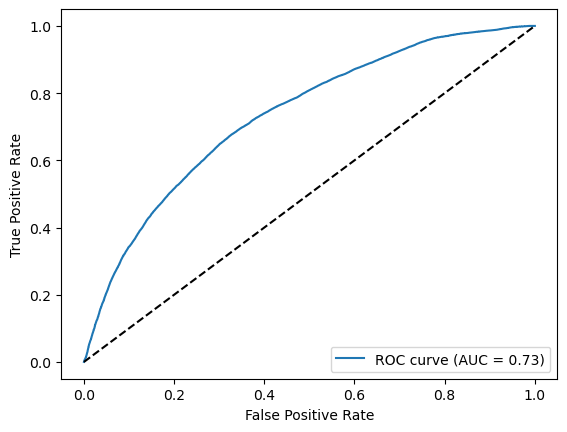

In [34]:
# Fit the train data to the model.  Predict the test data, calculate accuracy and recall, 
# compute confusion matrix, classification report & AUC, and finally plot the ROC curve.

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_prob = lr.predict_proba(X_test)[:, 1]

accuracy_lr = accuracy_score(y_test, y_pred)
precision_lr = precision_score(y_test, y_pred)
recall_lr = recall_score(y_test, y_pred)
print("Accuracy: ", accuracy_lr)
print("Precision: ", precision_lr)
print("Recall: ", recall_lr)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred_prob)
print("AUC: ", auc)
                    
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

#### 5.2.2 k-Nearest Neighbors (kNN)

In [193]:
# Use grid search to identify the optimal n_neighbors parameter. 
param_grid = {'n_neighbors': range(1, 21),'weights': ['uniform', 'distance'], 'p': [1, 2]}
knn = KNeighborsClassifier()
num_folds=5
knn_cv= GridSearchCV(knn, param_grid, cv=num_folds, scoring='accuracy')
knn_cv.fit(X_train, y_train)

print("Best Parameters: " + str(knn_cv.best_params_))
print("Best Accuracy Score:" + str(knn_cv.best_score_))

Best Parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best Accuracy Score:0.9800568956548066


In [16]:
# Perform cross-validation
knn = KNeighborsClassifier(n_neighbors=2, weights='distance', p=1)
num_folds = 5
cv_scores_knn = cross_val_score(knn, X_train, y_train, cv=num_folds, scoring='accuracy')
mean_cv_score_knn = np.mean(cv_scores_knn)
cv_scores_std_knn = cv_scores_knn.std()
print("Cross-validation Accuracy:", cv_scores_knn)
print("Mean cross-validation accuracy:", mean_cv_score_knn)
print("Standard deviation in cv accuracy:", cv_scores_std_knn)

Cross-validation Accuracy: [0.98021843 0.97965069 0.97971014 0.9806066  0.98009861]
Mean cross-validation accuracy: 0.9800568956548066
Standard deviation in cv accuracy: 0.0003507868416475809


In [17]:
# Fit the model on the training data and predict on the test data. 
# Calculate the accuracy score and confusion matrix. 

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
print("Accuracy: ", accuracy_knn)
print("Precision: ", precision_knn)
print("Recall: ", recall_knn)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.9824536240198891
Precision:  0.9680122210906398
Recall:  0.9979478858451847
[[40374  1382]
 [   86 41822]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     41756
           1       0.97      1.00      0.98     41908

    accuracy                           0.98     83664
   macro avg       0.98      0.98      0.98     83664
weighted avg       0.98      0.98      0.98     83664



#### 5.2.3 Random Forest

In [198]:
# Perform a grid search to pick the optimal hyperparameters.

param_grid = {'n_estimators':[50, 100, 250, 500], 'max_depth': [5, 10, 15, 20]}
rf = RandomForestClassifier()
num_folds=5
rf_cv = GridSearchCV(rf, param_grid, cv=num_folds, scoring='accuracy')
rf_cv.fit(X_train, y_train)
best_score = rf_cv.best_score_
best_hyperparameters = rf_cv.best_params_

print("Best Hyperparameters: ", best_hyperparameters)
print("Best Accuracy Score: ", best_score )

Best Hyperparameters:  {'max_depth': 20, 'n_estimators': 500}
Best Accuracy Score:  0.9892724385909377


In [20]:
# Perform cross-validation on the train set

rf = RandomForestClassifier(n_estimators = 500, max_depth = 20)
num_folds = 5
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=num_folds, scoring='accuracy')
mean_cv_score_rf = np.mean(cv_scores_rf)
cv_scores_std_rf = cv_scores_rf.std()
print("Cross-validation Accuracy:", cv_scores_rf)
print("Mean cross-validation accuracy:", mean_cv_score_rf)
print("Standard deviation in cv accuracy:", cv_scores_std_rf)

Cross-validation Accuracy: [0.98927253 0.98906336 0.98936202 0.98982519 0.98867473]
Mean cross-validation accuracy: 0.9892395686959565
Standard deviation in cv accuracy: 0.00037659513286394524


In [21]:
# Fit the model on the training data and predict on the test data. 
# Calculate the accuracy score and confusion matrix.

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
print("Accuracy: ", accuracy_rf)
print("Precision: ", precision_rf)
print("Recall:", recall_rf)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.9896968827691719
Precision:  0.9859355022020173
Recall: 0.9936050396105756
[[41162   594]
 [  268 41640]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     41756
           1       0.99      0.99      0.99     41908

    accuracy                           0.99     83664
   macro avg       0.99      0.99      0.99     83664
weighted avg       0.99      0.99      0.99     83664



#### 5.2.4 Gradient Boosting

In [9]:
# Use grid search to optimize the hyperparameters for the model. 
param_grid = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.1, 1.0], 
              'max_depth': [3, 5, 7]}
gb = GradientBoostingClassifier()
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Best Accuracy Score:  0.9942148856699369


In [24]:
# Perform cross-validation on the training set

gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=7, random_state=123) 
num_folds = 5
cv_scores_gb = cross_val_score(gb, X_test, y_test, cv=num_folds, scoring='accuracy')
mean_cv_score_gb = np.mean(cv_scores_gb)
cv_scores_std_gb = cv_scores_gb.std()
print("Cross-validation Accuracy:", cv_scores_gb)
print("Mean cross-validation accuracy:", mean_cv_score_gb)
print("Standard deviation in cv accuracy:", cv_scores_std_gb)

Cross-validation Accuracy: [0.99241021 0.99324688 0.99205163 0.99264926 0.99175233]
Mean cross-validation accuracy: 0.9924220612242977
Standard deviation in cv accuracy: 0.0005133876606807409


In [23]:
# Fit the model on the training data and predict on the test data. 
# Calculate the accuracy score and confusion matrix.

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred)
precision_gb = precision_score(y_test, y_pred)
recall_gb = recall_score(y_test, y_pred)
print("Accuracy: ", accuracy_gb)
print("Precision: ", precision_gb)
print("Recall:", recall_gb)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.9945137693631669
Precision:  0.9980773390372275
Recall: 0.9909563806433139
[[41676    80]
 [  379 41529]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     41756
           1       1.00      0.99      0.99     41908

    accuracy                           0.99     83664
   macro avg       0.99      0.99      0.99     83664
weighted avg       0.99      0.99      0.99     83664



#### 5.2.5 Extreme Gradient Boosting

Since the cross validation recall score is completely off the chart, we'll try the extreme gradient boosting classifier now, to see if it works better for our dataset. 

In [26]:
import xgboost as xgb

In [13]:
# Use grid search to optimize the hyperparameters for the model. 
param_grid = {'n_estimators': [100, 300, 500, 700, 900], 'learning_rate': [0.01, 0.1, 1.0], 
              'max_depth': [3, 5, 7, 9]}
xgb = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Recall Score: ", grid_search.best_score_)

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500}
Best Recall Score:  0.994716899309567


In [27]:
# Perform cross-validation on the training set

xgb = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=9, random_state=123)
num_folds = 5
cv_scores_xgb = cross_val_score(xgb, X_test, y_test, cv=num_folds, scoring='accuracy')
mean_cv_score_xgb = np.mean(cv_scores_xgb)
cv_scores_std_xgb = cv_scores_xgb.std()
print("Cross-validation Accuracy:", cv_scores_xgb)
print("Mean cross-validation Accuracy:", mean_cv_score_xgb)
print("Standard deviation in cv Accuracy:", cv_scores_std_xgb)

Cross-validation Accuracy: [0.99294807 0.9933664  0.99270902 0.99306759 0.99276835]
Mean cross-validation Accuracy: 0.9929718851174096
Standard deviation in cv Accuracy: 0.00023490281974392736


In [28]:
# Fit the model on the training data and predict on the test data. 
# Calculate the accuracy score and confusion matrix.

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
print("Accuracy: ", accuracy_xgb)
print("Precision: ", precision_xgb)
print("Recall:", recall_xgb)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.9947886785236183
Precision:  0.9982459512710846
Recall: 0.9913381693232796
[[41683    73]
 [  363 41545]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     41756
           1       1.00      0.99      0.99     41908

    accuracy                           0.99     83664
   macro avg       0.99      0.99      0.99     83664
weighted avg       0.99      0.99      0.99     83664



#### 5.2.6 Decision Trees

In [14]:
# Use grid search to optimize the hyperparameters for the model.

dt = DecisionTreeClassifier()
param_grid = {'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              'min_samples_split': [2, 5, 10, 15, 20],
              'min_samples_leaf': [1, 2, 4, 7, 10]}
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': 35, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Accuracy Score:  0.9855222712942734


In [29]:
# Perform cross-validation on the training set

dt = DecisionTreeClassifier(max_depth=35, min_samples_leaf=1, min_samples_split=5, random_state=123)
num_folds = 5
cv_scores_dt = cross_val_score(dt, X_train,  y_train, cv=num_folds, scoring='accuracy')
mean_cv_score_dt = np.mean(cv_scores_dt)
cv_scores_std_dt = cv_scores_dt.std()
print("Cross-validation Accuracy:", cv_scores_dt)
print("Mean cross-validation Accuracy:", mean_cv_score_dt)
print("Standard deviation in cv Accuracy:", cv_scores_std_dt)

Cross-validation Accuracy: [0.98662802 0.98541782 0.98514866 0.98528313 0.98493949]
Mean cross-validation Accuracy: 0.9854834243363566
Standard deviation in cv Accuracy: 0.0005937088931176012


In [30]:
# Fit the model on the training data and predict on the test data. 
# Calculate the accuracy score and confusion matrix.

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred)
precision_dt = precision_score(y_test, y_pred)
recall_dt = recall_score(y_test, y_pred)
print("Accuracy: ", accuracy_dt)
print("Precision: ", precision_dt)
print("Recall:", recall_dt)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.9870075540256263
Precision:  0.9885349098829556
Recall: 0.9854920301613057
[[41277   479]
 [  608 41300]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     41756
           1       0.99      0.99      0.99     41908

    accuracy                           0.99     83664
   macro avg       0.99      0.99      0.99     83664
weighted avg       0.99      0.99      0.99     83664



### 5.3 Comparison of Models

Now that we've run 6 different models, let's compare the scores and pick the one that works the best and delivers the highest score.  Since we are investigating flight cancellation, and every flight cancellation will cause a lot of economic loss for the company, we want a model that is able to capture every since possible ture positive case, hence recall is the most important score that we'll use to evaluate the effectiveness of the model. 

In [36]:
Labels = ['Logistic Regression','KNN', 'Random Forest','Gradient Boost', 
            'Extreme Gradient Boost', 'Decision Tree']
Accuracy = [accuracy_lr,accuracy_knn,accuracy_rf,accuracy_gb,accuracy_xgb,accuracy_dt]
Precision = [precision_lr,precision_knn,precision_rf,precision_gb,precision_xgb,precision_dt]
Recall = [recall_lr,recall_knn,recall_rf,recall_gb,recall_xgb,recall_dt]

score_tab = pd.DataFrame(list(zip(Labels, Accuracy, Precision, Recall)), 
               columns =['Algorithm', 'Accuracy', 'Precision', 'Recall']) 
print(score_tab)

                Algorithm  Accuracy  Precision    Recall
0     Logistic Regression  0.671029   0.652620  0.733893
1                     KNN  0.982454   0.968012  0.997948
2           Random Forest  0.989697   0.985936  0.993605
3          Gradient Boost  0.994514   0.998077  0.990956
4  Extreme Gradient Boost  0.994789   0.998246  0.991338
5           Decision Tree  0.987008   0.988535  0.985492


In our case, every single flight cancellation will lead to financial loss for the company.  As a result, we want to identify and avoid as many potential flight cancellations as possible.  That means a high recall score is much more important than any other performance score.  Since the KNN model delivers the highest recall score of 99.7948%, and the precision and accuracy scores from KNN is reasonabley high in the 98% range, KNN is our best perfomring model.

Since KNN algorithm is a distance-based algorithm, it doesn't learn a set of weights or coefficients that represent the importance of each feature. Instead, it calculates the distances between the query point and the training points, and uses the labels of the k-nearest neighbors to make predictions. Therefore, the importance of each feature is implicitly determined by the distance metric used and the distribution of the data.

In order to get an idea of which features are most important for KNN, we'll use the feature permutation technique.

In [38]:
from sklearn.inspection import permutation_importance

In [39]:
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=123)

                             Importance
DESTINATION_AIRPORT_ENCODED    0.408993
DAY_OF_WEEK_SCALED             0.271775
DESTINATION_STATE_ENCODED      0.260433
DAY_SCALED                     0.240243
AIRLINE_ENCODED                0.233756
MONTH_SCALED                   0.226292
FLIGHT_NUMBER_SCALED           0.186029
SCHEDULED_ARRIVAL_SCALED       0.015040
SCHEDULED_DEPARTURE_SCALED     0.009878
SCHEDULED_TIME_SCALED          0.001131
DISTANCE_SCALED                0.000078


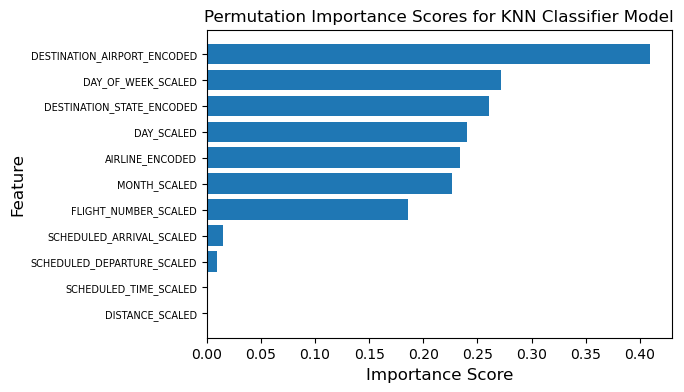

In [71]:
# Sort & plot the permutation importance scores for all features.

feature_importance = pd.DataFrame(index=X.columns)
feature_importance['Importance'] = result.importances_mean
feature_importance = feature_importance.sort_values('Importance')
print(feature_importance.sort_values('Importance', ascending=False))

plt.figure(figsize=(6, 4))
plt.barh(feature_importance.index, feature_importance['Importance'])
plt.xlabel("Importance Score", size=12)
plt.ylabel("Feature", size=12)
plt.yticks(size=7)
plt.title("Permutation Importance Scores for KNN Classifier Model")
plt.show()


### 5.4 Conclusion:

In order to predict the flight cancellations, we have considered a group of 11 features.  The features that have the most impact on flight cancellations are destination airports, days of week, destination states, days, airlines, months and flight numbers. 

This is a classification problem, so we've tried the below 6 classification models:

    1. Logistic Regression
    2. k-Nearest Neighbors
    3. Random Forests
    4. Gradient Boosting
    5. Extemem Gradient Boosting
    6. Decision Trees
    
For each model, we've followed the same process.  First, we use grid search to find out the optimal hyperparameters for the model.  Then, we train the model and cross validate it using 5-fold CV approach. Finally, we predict the test data and calculate performance scores like accuracy, precision, recall, etc.

We then evaluated each models in terms of model accuracy score, precision score and recall score.  Since we care most about the true positive cases, we've chosen KNN as teh best performing model based on the recall score.